In [331]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [332]:
train_batch = next(iter(train_loader))

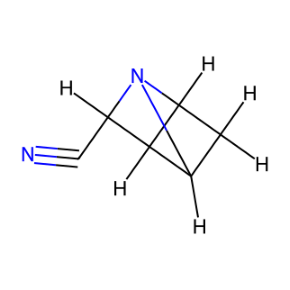

In [333]:
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
if batch_size > 1:
    axs = axs.flatten()

for i in range(len(train_batch)):
    batch_mask = train_batch.batch == i
    
    graph = train_batch[i]
    mol = graph_to_mol(data=graph, includes_h=True, validate=False)
    if batch_size > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")

plt.tight_layout()
plt.show()

In [334]:
from typing import Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

class MixtureModelDecoder(nn.Module):

    def __init__(self, hparams: Dict[str, Any]) -> None:
        super().__init__()

        num_clusters = hparams["num_clusters"]
        latent_dim = hparams["latent_dim"]
        num_atom_types = hparams["num_atom_types"]
        num_bond_types = hparams["num_bond_types"] + 1  # +1 for non-existent bonds

        # model parameters
        init_cluster_means = torch.randn(1, num_clusters, latent_dim)
        self.cluster_means = nn.Parameter(init_cluster_means)

        init_cluster_log_sigmas = torch.randn(1, num_clusters, latent_dim)
        self.cluster_log_sigmas = nn.Parameter(init_cluster_log_sigmas)

        self.atom_classifier = nn.Sequential(
            nn.Linear(latent_dim, num_atom_types),
            nn.Softmax(dim=1)
        )

        init_bond_matrix = torch.randn(1, num_bond_types, latent_dim, latent_dim)
        self.bond_matrix = nn.Parameter(init_bond_matrix)


    def forward(self, eta: torch.Tensor, batch_index: torch.Tensor) -> Data:

        pi = F.softmax(eta, dim=1)

        train_batch_atom_counts = torch.bincount(batch_index)
        pi = torch.repeat_interleave(pi, train_batch_atom_counts, dim=0)

        # TODO: anneal tau during training
        tau = 0.1
        c = F.gumbel_softmax(logits=pi, tau=tau, hard=True).unsqueeze(-1)

        mu = torch.sum(self.cluster_means * c, dim=1)
        log_sigma = torch.sum(self.cluster_log_sigmas * c, dim=1)
        sigma = torch.exp(log_sigma)

        z = torch.randn_like(mu) * sigma + mu

        atom_types = self.atom_classifier(z)
        
        print(z.shape)
        # TODO: sample edges types

        return atom_types


num_clusters = 5
hparams = {
    "num_clusters": num_clusters,
    "latent_dim": 2,
    "num_atom_types": dataset.num_node_features,
    "num_bond_types": dataset.num_edge_features,
}

print(hparams)

decoder_model = MixtureModelDecoder(hparams=hparams).to(device)

eta = torch.randn((batch_size, num_clusters), device=device)

atom_types_one_hot = decoder_model(eta, train_batch.batch)

{'num_clusters': 5, 'latent_dim': 2, 'num_atom_types': 5, 'num_bond_types': 4}
torch.Size([14, 2])


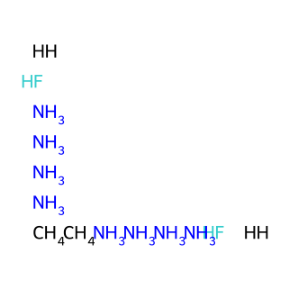

In [335]:
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
if batch_size > 1:
    axs = axs.flatten()

for i in range(len(train_batch)):
    batch_mask = train_batch.batch == i
    
    graph = Data(x=atom_types_one_hot[batch_mask])
    mol = graph_to_mol(data=graph, includes_h=True, validate=False)
    if batch_size > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")

plt.tight_layout()
plt.show()

In [350]:
import itertools


N = 4
type_count = 2

W = torch.randn(1, type_count, 3, 3)
z = torch.randn(N, 3)


edge_index = list(itertools.combinations(range(N), 2))
print(edge_index)

z = z.unsqueeze(1).unsqueeze(-1)
z_pairs = torch.stack([z[list(pair)] for pair in edge_index])


# make W symmetric
W = (W + W.transpose(2, 3)) * 0.5

E = z_pairs[:, 0].permute(dims=(0, 1, 3, 2)) @ W @ z_pairs[:, 1]
E = F.softmax(E, dim=1)
E

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


tensor([[[[9.9801e-01]],

         [[1.9853e-03]]],


        [[[8.1841e-01]],

         [[1.8159e-01]]],


        [[[5.5338e-02]],

         [[9.4466e-01]]],


        [[[9.6545e-01]],

         [[3.4549e-02]]],


        [[[9.9995e-01]],

         [[5.4531e-05]]],


        [[[9.8853e-01]],

         [[1.1473e-02]]]])

In [344]:
z = torch.randn(N, 3)
z = z.unsqueeze(1).unsqueeze(-1)
z_pairs = torch.stack([z[list(pair)] for pair in edge_index])

In [307]:
z.shape

torch.Size([4, 1, 3, 1])

In [345]:
z_pairs.shape

torch.Size([6, 2, 1, 3, 1])

In [346]:
z_pairs[:, 0].shape

torch.Size([6, 1, 3, 1])